In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(540704, 828)
(540704, 1)
validation
(80437, 828)
(80437, 1)
test
(63506, 828)
(63506, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/55 [..............................] - ETA: 1:09 - loss: 0.0470 - STD: 1.1767e-04 - MAE: 0.2082

 4/55 [=>............................] - ETA: 1s - loss: 0.0282 - STD: 2.1308e-04 - MAE: 0.1263  

 5/55 [=>............................] - ETA: 1s - loss: 0.0286 - STD: 2.0616e-04 - MAE: 0.1269

 6/55 [==>...........................] - ETA: 2s - loss: 0.0281 - STD: 2.1088e-04 - MAE: 0.1250

 7/55 [==>...........................] - ETA: 2s - loss: 0.0272 - STD: 2.2700e-04 - MAE: 0.1208

 8/55 [===>..........................] - ETA: 2s - loss: 0.0257 - STD: 2.5153e-04 - MAE: 0.1145

 9/55 [===>..........................] - ETA: 2s - loss: 0.0243 - STD: 2.8200e-04 - MAE: 0.1088

10/55 [====>.........................] - ETA: 2s - loss: 0.0233 - STD: 3.1546e-04 - MAE: 0.1063

11/55 [=====>........................] - ETA: 2s - loss: 0.0226 - STD: 3.4872e-04 - MAE: 0.1062

12/55 [=====>........................] - ETA: 2s - loss: 0.0222 - STD: 3.8128e-04 - MAE: 0.1073

13/55 [======>.......................] - ETA: 2s - loss: 0.0219 - STD: 4.1246e-04 - MAE: 0.1082

14/55 [======>.......................] - ETA: 2s - loss: 0.0215 - STD: 4.4150e-04 - MAE: 0.1082

15/55 [=======>......................] - ETA: 2s - loss: 0.0210 - STD: 4.6810e-04 - MAE: 0.1073

16/55 [=======>......................] - ETA: 2s - loss: 0.0205 - STD: 4.9174e-04 - MAE: 0.1055

17/55 [========>.....................] - ETA: 2s - loss: 0.0200 - STD: 5.1252e-04 - MAE: 0.1033

18/55 [========>.....................] - ETA: 2s - loss: 0.0196 - STD: 5.3081e-04 - MAE: 0.1010

19/55 [=========>....................] - ETA: 2s - loss: 0.0193 - STD: 5.4831e-04 - MAE: 0.0990

20/55 [=========>....................] - ETA: 2s - loss: 0.0191 - STD: 5.6448e-04 - MAE: 0.0972

21/55 [==========>...................] - ETA: 2s - loss: 0.0189 - STD: 5.8120e-04 - MAE: 0.0956

22/55 [===========>..................] - ETA: 2s - loss: 0.0187 - STD: 5.9950e-04 - MAE: 0.0942

23/55 [===========>..................] - ETA: 2s - loss: 0.0185 - STD: 6.1924e-04 - MAE: 0.0929

24/55 [============>.................] - ETA: 1s - loss: 0.0183 - STD: 6.4147e-04 - MAE: 0.0917

25/55 [============>.................] - ETA: 1s - loss: 0.0181 - STD: 6.6549e-04 - MAE: 0.0907

26/55 [=============>................] - ETA: 1s - loss: 0.0179 - STD: 6.9194e-04 - MAE: 0.0901

27/55 [=============>................] - ETA: 1s - loss: 0.0177 - STD: 7.2060e-04 - MAE: 0.0897

28/55 [==============>...............] - ETA: 1s - loss: 0.0176 - STD: 7.5064e-04 - MAE: 0.0895

29/55 [==============>...............] - ETA: 1s - loss: 0.0174 - STD: 7.8203e-04 - MAE: 0.0894

30/55 [===============>..............] - ETA: 1s - loss: 0.0173 - STD: 8.1500e-04 - MAE: 0.0894

31/55 [===============>..............] - ETA: 1s - loss: 0.0172 - STD: 8.4841e-04 - MAE: 0.0893

32/55 [================>.............] - ETA: 1s - loss: 0.0170 - STD: 8.8178e-04 - MAE: 0.0890

33/55 [=================>............] - ETA: 1s - loss: 0.0169 - STD: 9.1592e-04 - MAE: 0.0886

34/55 [=================>............] - ETA: 1s - loss: 0.0168 - STD: 9.4987e-04 - MAE: 0.0881

35/55 [==================>...........] - ETA: 1s - loss: 0.0166 - STD: 9.8463e-04 - MAE: 0.0874

36/55 [==================>...........] - ETA: 1s - loss: 0.0165 - STD: 0.0010 - MAE: 0.0868    

37/55 [===================>..........] - ETA: 1s - loss: 0.0164 - STD: 0.0011 - MAE: 0.0862

38/55 [===================>..........] - ETA: 1s - loss: 0.0164 - STD: 0.0011 - MAE: 0.0856

39/55 [====================>.........] - ETA: 1s - loss: 0.0163 - STD: 0.0011 - MAE: 0.0850

40/55 [====================>.........] - ETA: 0s - loss: 0.0162 - STD: 0.0012 - MAE: 0.0845

41/55 [=====================>........] - ETA: 0s - loss: 0.0161 - STD: 0.0012 - MAE: 0.0841

42/55 [=====================>........] - ETA: 0s - loss: 0.0160 - STD: 0.0013 - MAE: 0.0838

43/55 [======================>.......] - ETA: 0s - loss: 0.0159 - STD: 0.0014 - MAE: 0.0835

44/55 [=======================>......] - ETA: 0s - loss: 0.0159 - STD: 0.0014 - MAE: 0.0833

45/55 [=======================>......] - ETA: 0s - loss: 0.0158 - STD: 0.0015 - MAE: 0.0832

46/55 [========================>.....] - ETA: 0s - loss: 0.0157 - STD: 0.0016 - MAE: 0.0830

47/55 [========================>.....] - ETA: 0s - loss: 0.0156 - STD: 0.0016 - MAE: 0.0829

48/55 [=========================>....] - ETA: 0s - loss: 0.0156 - STD: 0.0017 - MAE: 0.0827

49/55 [=========================>....] - ETA: 0s - loss: 0.0155 - STD: 0.0018 - MAE: 0.0825

50/55 [==========================>...] - ETA: 0s - loss: 0.0154 - STD: 0.0019 - MAE: 0.0822

51/55 [==========================>...] - ETA: 0s - loss: 0.0154 - STD: 0.0020 - MAE: 0.0819

55/55 [==============================] - ETA: 0s - loss: 0.0151 - STD: 0.0025 - MAE: 0.0806

55/55 [==============================] - 6s 83ms/step - loss: 0.0151 - STD: 0.0025 - MAE: 0.0806 - val_loss: 0.0135 - val_STD: 0.0109 - val_MAE: 0.0807


Epoch 2/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0111 - STD: 0.0118 - MAE: 0.0644

 2/55 [>.............................] - ETA: 3s - loss: 0.0108 - STD: 0.0125 - MAE: 0.0647

 3/55 [>.............................] - ETA: 3s - loss: 0.0108 - STD: 0.0132 - MAE: 0.0655

 4/55 [=>............................] - ETA: 3s - loss: 0.0110 - STD: 0.0140 - MAE: 0.0664

 5/55 [=>............................] - ETA: 3s - loss: 0.0108 - STD: 0.0148 - MAE: 0.0664

 6/55 [==>...........................] - ETA: 3s - loss: 0.0108 - STD: 0.0157 - MAE: 0.0665

 7/55 [==>...........................] - ETA: 3s - loss: 0.0107 - STD: 0.0167 - MAE: 0.0662

 8/55 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 0.0177 - MAE: 0.0658

 9/55 [===>..........................] - ETA: 3s - loss: 0.0104 - STD: 0.0187 - MAE: 0.0650

10/55 [====>.........................] - ETA: 3s - loss: 0.0103 - STD: 0.0198 - MAE: 0.0643

11/55 [=====>........................] - ETA: 2s - loss: 0.0102 - STD: 0.0211 - MAE: 0.0636

12/55 [=====>........................] - ETA: 2s - loss: 0.0100 - STD: 0.0223 - MAE: 0.0628

13/55 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 0.0238 - MAE: 0.0622

14/55 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0253 - MAE: 0.0616

15/55 [=======>......................] - ETA: 2s - loss: 0.0096 - STD: 0.0269 - MAE: 0.0611

16/55 [=======>......................] - ETA: 2s - loss: 0.0094 - STD: 0.0287 - MAE: 0.0606

17/55 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 0.0304 - MAE: 0.0601

18/55 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.0322 - MAE: 0.0596

19/55 [=========>....................] - ETA: 2s - loss: 0.0089 - STD: 0.0340 - MAE: 0.0591

20/55 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.0358 - MAE: 0.0586

21/55 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0375 - MAE: 0.0581

22/55 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0393 - MAE: 0.0576

23/55 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.0409 - MAE: 0.0571

24/55 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0426 - MAE: 0.0566

25/55 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0442 - MAE: 0.0561

26/55 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.0456 - MAE: 0.0557

27/55 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.0470 - MAE: 0.0552

28/55 [==============>...............] - ETA: 1s - loss: 0.0077 - STD: 0.0483 - MAE: 0.0548

29/55 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0495 - MAE: 0.0544

30/55 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0506 - MAE: 0.0539

31/55 [===============>..............] - ETA: 1s - loss: 0.0074 - STD: 0.0517 - MAE: 0.0536

32/55 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0530 - MAE: 0.0532

33/55 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0542 - MAE: 0.0528

34/55 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0553 - MAE: 0.0525

35/55 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0563 - MAE: 0.0521

36/55 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0573 - MAE: 0.0518

37/55 [===================>..........] - ETA: 1s - loss: 0.0068 - STD: 0.0584 - MAE: 0.0514

38/55 [===================>..........] - ETA: 1s - loss: 0.0068 - STD: 0.0594 - MAE: 0.0512

39/55 [====================>.........] - ETA: 1s - loss: 0.0067 - STD: 0.0603 - MAE: 0.0509

40/55 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0612 - MAE: 0.0506

41/55 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0620 - MAE: 0.0503

42/55 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0627 - MAE: 0.0500

43/55 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0634 - MAE: 0.0497

44/55 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0641 - MAE: 0.0495

45/55 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0648 - MAE: 0.0493

46/55 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0655 - MAE: 0.0491

48/55 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0666 - MAE: 0.0486

49/55 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0671 - MAE: 0.0484

50/55 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0677 - MAE: 0.0482

51/55 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0480

52/55 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0478

53/55 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0694 - MAE: 0.0477

54/55 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0698 - MAE: 0.0475

55/55 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0703 - MAE: 0.0473

55/55 [==============================] - 4s 71ms/step - loss: 0.0058 - STD: 0.0703 - MAE: 0.0473 - val_loss: 0.0046 - val_STD: 0.0969 - val_MAE: 0.0501


Epoch 3/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0974 - MAE: 0.0370

 2/55 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0996 - MAE: 0.0378

 3/55 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0998 - MAE: 0.0377

 4/55 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0984 - MAE: 0.0377

 5/55 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0971 - MAE: 0.0376

 6/55 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0970 - MAE: 0.0377

 7/55 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0978 - MAE: 0.0377

 8/55 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0979 - MAE: 0.0377

 9/55 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0975 - MAE: 0.0377

10/55 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0969 - MAE: 0.0377

11/55 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0376

12/55 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0973 - MAE: 0.0375

13/55 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0976 - MAE: 0.0375

14/55 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0976 - MAE: 0.0374

15/55 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0972 - MAE: 0.0374

16/55 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0971 - MAE: 0.0373

17/55 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0972 - MAE: 0.0373

19/55 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0973 - MAE: 0.0372

20/55 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0371

21/55 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0371

22/55 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0973 - MAE: 0.0371

23/55 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0975 - MAE: 0.0370

24/55 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0976 - MAE: 0.0370

25/55 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0975 - MAE: 0.0370

26/55 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0974 - MAE: 0.0369

27/55 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0975 - MAE: 0.0369

28/55 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0977 - MAE: 0.0369

29/55 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0979 - MAE: 0.0369

30/55 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0978 - MAE: 0.0368

31/55 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0978 - MAE: 0.0368

32/55 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0978 - MAE: 0.0367

33/55 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0979 - MAE: 0.0367

34/55 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0980 - MAE: 0.0366

35/55 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0981 - MAE: 0.0366

36/55 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0980 - MAE: 0.0365

37/55 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0980 - MAE: 0.0365

38/55 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0981 - MAE: 0.0365

39/55 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0981 - MAE: 0.0365

40/55 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0982 - MAE: 0.0364

41/55 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0981 - MAE: 0.0364

42/55 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0981 - MAE: 0.0364

43/55 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0982 - MAE: 0.0363

44/55 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0983 - MAE: 0.0363

45/55 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0983 - MAE: 0.0362

46/55 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0983 - MAE: 0.0362

47/55 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0984 - MAE: 0.0362

48/55 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0362

49/55 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0361

50/55 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0361

51/55 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0361

52/55 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0360

53/55 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0360

54/55 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0360

55/55 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0359

55/55 [==============================] - 4s 72ms/step - loss: 0.0030 - STD: 0.0988 - MAE: 0.0359 - val_loss: 0.0030 - val_STD: 0.1068 - val_MAE: 0.0402


Epoch 4/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

 2/55 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1031 - MAE: 0.0338

 3/55 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0340

 4/55 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0340

 5/55 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0339

 6/55 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0339

 7/55 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0339

 8/55 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0339

 9/55 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0339

10/55 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0338

11/55 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0337

12/55 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0337

13/55 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0337

14/55 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0337

15/55 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0337

16/55 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0337

17/55 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0337

18/55 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0337

19/55 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0336

20/55 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0336

21/55 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0336

22/55 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0336

23/55 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0336

24/55 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0335

26/55 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0334

27/55 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0334

28/55 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0334

29/55 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0334

30/55 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0334

31/55 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0334

32/55 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0333

33/55 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0333

34/55 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0333

35/55 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0333

36/55 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0332

37/55 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0332

38/55 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0332

39/55 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0332

40/55 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0332

41/55 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0332

42/55 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0332

43/55 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0332

44/55 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0332

45/55 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0332

46/55 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0332

47/55 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0332

48/55 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0332

49/55 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0331

50/55 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0331

51/55 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0331

52/55 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0331

53/55 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0331

54/55 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0331

55/55 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0331

55/55 [==============================] - 4s 74ms/step - loss: 0.0024 - STD: 0.1016 - MAE: 0.0331 - val_loss: 0.0024 - val_STD: 0.1099 - val_MAE: 0.0370


Epoch 5/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0323

 2/55 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0325

 3/55 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0324

 4/55 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0324

 5/55 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0324

 6/55 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0324

 7/55 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1029 - MAE: 0.0323

 8/55 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0322

 9/55 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0322

10/55 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0322

11/55 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0322

12/55 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0320

13/55 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0320

14/55 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0320

15/55 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0320

16/55 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0320

17/55 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0320

18/55 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0320

19/55 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0320

20/55 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0320

21/55 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

22/55 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

23/55 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

24/55 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0319

26/55 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0319

27/55 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

28/55 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

29/55 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0319

30/55 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

31/55 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

32/55 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

33/55 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0319

34/55 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0318

35/55 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0318

36/55 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0318

37/55 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0318

38/55 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0318

39/55 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0318

40/55 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0318

41/55 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0318

42/55 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0318

43/55 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0318

44/55 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0317

45/55 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0318

46/55 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

47/55 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

48/55 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

49/55 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

50/55 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

51/55 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

52/55 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

53/55 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

54/55 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

55/55 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

55/55 [==============================] - 4s 72ms/step - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317 - val_loss: 0.0023 - val_STD: 0.1167 - val_MAE: 0.0353


Epoch 6/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0306

 2/55 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0307

 3/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0309

 4/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 5/55 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0312

 6/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 7/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 8/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 9/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0311

10/55 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

11/55 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0311

13/55 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0312

14/55 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0311

15/55 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1039 - MAE: 0.0312

16/55 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0312

17/55 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0312

18/55 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1038 - MAE: 0.0312

19/55 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0313

20/55 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0313

21/55 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0313

22/55 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0313

23/55 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0313

24/55 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0313

25/55 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0313

26/55 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0312

27/55 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0312

28/55 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0312

29/55 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0312

30/55 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0311

31/55 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0311

32/55 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0311

33/55 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0311

34/55 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0311

36/55 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0311

37/55 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0311

38/55 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0311

39/55 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0311

40/55 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0311

41/55 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0311

42/55 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0311

43/55 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0311

44/55 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0311

45/55 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0310

46/55 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0310

47/55 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0311

48/55 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0311

49/55 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0311

50/55 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0310

51/55 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0310

52/55 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0310

53/55 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0310

54/55 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0310

55/55 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0311

55/55 [==============================] - 4s 72ms/step - loss: 0.0022 - STD: 0.1033 - MAE: 0.0311 - val_loss: 0.0022 - val_STD: 0.1180 - val_MAE: 0.0351


Epoch 7/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1052 - MAE: 0.0305

 4/55 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0309

 5/55 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0316

 6/55 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0322

 7/55 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0319

 8/55 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0324

 9/55 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0331

10/55 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0329

11/55 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0338

12/55 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0339

13/55 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0341

14/55 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0342

15/55 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0340

16/55 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0341

17/55 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0340

18/55 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0340

19/55 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0339

20/55 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0338

21/55 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0337

22/55 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0337

23/55 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0336

24/55 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0335

25/55 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0334

26/55 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0333

27/55 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0333

28/55 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0332

29/55 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0332

30/55 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0331

31/55 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0331

32/55 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0330

33/55 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0330

34/55 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0329

35/55 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0329

36/55 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0328

37/55 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0328

38/55 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0328

39/55 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0327

40/55 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0327

41/55 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0326

42/55 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0326

43/55 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0325

44/55 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0325

45/55 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0324

46/55 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0324

47/55 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0324

48/55 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0323

49/55 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0323

50/55 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0323

51/55 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0322

52/55 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0322

53/55 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0321

54/55 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0321

55/55 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0321

55/55 [==============================] - 4s 72ms/step - loss: 0.0023 - STD: 0.1029 - MAE: 0.0321 - val_loss: 0.0023 - val_STD: 0.1180 - val_MAE: 0.0346


Epoch 8/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0311

 2/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0306

 3/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0307

 4/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0307

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0306

 6/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0306

 7/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0305

 8/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0305

 9/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0305

10/55 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0305

11/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

14/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

16/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

17/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

18/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0305

19/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

20/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

21/55 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

22/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0304

23/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

24/55 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0304

25/55 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0304

26/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

27/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0304

28/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

29/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

30/55 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

31/55 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

32/55 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

33/55 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

34/55 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0304

35/55 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0304

36/55 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

37/55 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0304

38/55 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0304

39/55 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0304

40/55 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0304

41/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

42/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

43/55 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

44/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

45/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

46/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0303

47/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

48/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

49/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

50/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

51/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0303

52/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0303

53/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

54/55 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

55/55 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303

55/55 [==============================] - 4s 72ms/step - loss: 0.0021 - STD: 0.1039 - MAE: 0.0303 - val_loss: 0.0021 - val_STD: 0.1168 - val_MAE: 0.0347


Epoch 9/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 2/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0302

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0300

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0300

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0300

 8/55 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0301

 9/55 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0301

10/55 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0303

13/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0303

14/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0304

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

16/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

17/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0305

18/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

19/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

20/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0304

21/55 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

22/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

23/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

24/55 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

25/55 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

26/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

27/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

28/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

29/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

55/55 [==============================] - 4s 71ms/step - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302 - val_loss: 0.0021 - val_STD: 0.1181 - val_MAE: 0.0348


Epoch 10/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0297

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1063 - MAE: 0.0301

 3/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0306

 4/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0306

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0307

 6/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0310

 7/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1054 - MAE: 0.0309

 8/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1053 - MAE: 0.0307

 9/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1048 - MAE: 0.0308

10/55 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0308

11/55 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1047 - MAE: 0.0307

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0306

13/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0305

14/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0305

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0304

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

24/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

25/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

26/55 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0302

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

40/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

55/55 [==============================] - 4s 72ms/step - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302 - val_loss: 0.0021 - val_STD: 0.1176 - val_MAE: 0.0347


Epoch 11/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0291

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0298

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0298

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0297

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0297

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0301

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0302

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0301

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0302

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0301

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0301

24/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0301

25/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0301

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0301

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0301

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0301

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0301

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0301

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0300

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0300

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

40/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0300

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0299

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299

55/55 [==============================] - 4s 72ms/step - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299 - val_loss: 0.0021 - val_STD: 0.1177 - val_MAE: 0.0347


Epoch 12/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0293

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0295

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0295

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

 9/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0295

10/55 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

11/55 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0296

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0296

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0297

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0298

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0298

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0298

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0298

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0298

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0298

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0298

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

24/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

25/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0298

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0299

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0299

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0299

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0300

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0304

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0304

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0304

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0305

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0306

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0306

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0306

50/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0307

51/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0308

52/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0308

53/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0309

54/55 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0309

55/55 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0309

55/55 [==============================] - 4s 71ms/step - loss: 0.0021 - STD: 0.1044 - MAE: 0.0309 - val_loss: 0.0027 - val_STD: 0.1231 - val_MAE: 0.0360


Epoch 13/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1087 - MAE: 0.0334

 2/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0315

 3/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1043 - MAE: 0.0318

 4/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0313

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0315

 6/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0314

 7/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0313

 8/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0312

 9/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0310

11/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0307

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0306

13/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0307

14/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0306

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0306

16/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0305

17/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0305

18/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0304

19/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0304

20/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0304

21/55 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0303

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

24/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0301

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0299

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0299

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0299

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0299

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0298

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

55/55 [==============================] - 4s 71ms/step - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298 - val_loss: 0.0021 - val_STD: 0.1197 - val_MAE: 0.0342


Epoch 14/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0297

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0297

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

 9/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

10/55 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

24/55 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

25/55 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

39/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

55/55 [==============================] - 4s 70ms/step - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295 - val_loss: 0.0020 - val_STD: 0.1190 - val_MAE: 0.0346


Epoch 15/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0293

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0293

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0292

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0292

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0292

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

 9/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

10/55 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

11/55 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

24/55 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0296

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0296

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0296

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

39/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

40/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

55/55 [==============================] - 4s 69ms/step - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296 - val_loss: 0.0020 - val_STD: 0.1180 - val_MAE: 0.0345


Epoch 16/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0298

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0296

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0294

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0294

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0294

 6/55 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0294

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0294

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0294

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0294

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0294

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0294

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0294

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0294

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0293

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0293

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0293

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0293

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

38/55 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

55/55 [==============================] - 3s 63ms/step - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294 - val_loss: 0.0024 - val_STD: 0.1251 - val_MAE: 0.0341


Epoch 17/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

 2/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0315

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1070 - MAE: 0.0312

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0307

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0304

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0303

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0302

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0301

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0300

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0300

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0299

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0299

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0299

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0298

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

55/55 [==============================] - 4s 63ms/step - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.1193 - val_MAE: 0.0336


Epoch 18/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0294

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0298

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0302

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0304

 6/55 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 7/55 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0302

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0300

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0300

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0299

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0300

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0301

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0302

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

22/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0301

23/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0301

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0301

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0301

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0300

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0300

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0300

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0299

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0299

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0299

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0299

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0299

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0299

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0298

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

55/55 [==============================] - 3s 62ms/step - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.1216 - val_MAE: 0.0342


Epoch 19/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1084 - MAE: 0.0302

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0297

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0295

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0293

 5/55 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

 6/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0294

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

55/55 [==============================] - 4s 63ms/step - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294 - val_loss: 0.0020 - val_STD: 0.1203 - val_MAE: 0.0333


Epoch 20/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0292

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0291

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0291

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0291

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0291

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0292

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0292

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0292

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0293

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0293

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0294

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0294

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

55/55 [==============================] - 4s 64ms/step - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294 - val_loss: 0.0022 - val_STD: 0.1227 - val_MAE: 0.0331


Epoch 21/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0299

 2/55 [>.............................] - ETA: 5s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0297

 3/55 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

 4/55 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0293

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

 9/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0298

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0299

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0298

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0298

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0299

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0300

23/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0302

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0302

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0302

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

39/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0303

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0303

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0305

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0306

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0306

55/55 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1046 - MAE: 0.0306 - val_loss: 0.0021 - val_STD: 0.1143 - val_MAE: 0.0362


Epoch 22/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0302

 2/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0329

 3/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0318

 4/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0319

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0318

 6/55 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0314

 7/55 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0315

 8/55 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0312

 9/55 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1054 - MAE: 0.0314

10/55 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0312

11/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0312

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0312

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0310

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0310

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0309

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0308

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0307

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0306

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0306

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0300

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0300

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0300

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0299

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0299

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0299

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0298

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0298

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

55/55 [==============================] - 4s 68ms/step - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295 - val_loss: 0.0020 - val_STD: 0.1218 - val_MAE: 0.0330


Epoch 23/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0295

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0291

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0290

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1059 - MAE: 0.0291

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0290

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1059 - MAE: 0.0290

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0290

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0291

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0291

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0295

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

24/55 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

39/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

55/55 [==============================] - 4s 71ms/step - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292 - val_loss: 0.0020 - val_STD: 0.1222 - val_MAE: 0.0329


Epoch 24/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0283

 2/55 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0285

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0285

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

11/55 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0288

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0288

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0288

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0288

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0288

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0288

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0289

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0290

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0290

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0290

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

55/55 [==============================] - 4s 71ms/step - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289 - val_loss: 0.0021 - val_STD: 0.1240 - val_MAE: 0.0324


Epoch 25/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0293

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0293

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0289

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0289

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0289

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0289

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0289

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0289

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0289

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0288

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0289

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0289

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0288

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

55/55 [==============================] - 4s 72ms/step - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290 - val_loss: 0.0020 - val_STD: 0.1182 - val_MAE: 0.0350


Epoch 26/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0302

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

 9/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

10/55 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

11/55 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

12/55 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0293

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0293

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0293

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0293

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0293

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0293

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

24/55 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

25/55 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0293

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0293

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0293

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0293

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0292

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0292

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0292

39/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0292

40/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0291

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0291

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0291

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0291

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

55/55 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291 - val_loss: 0.0021 - val_STD: 0.1240 - val_MAE: 0.0324


Epoch 27/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1080 - MAE: 0.0295

 2/55 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0290

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0287

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0286

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0286

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0287

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0287

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

55/55 [==============================] - 4s 71ms/step - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288 - val_loss: 0.0020 - val_STD: 0.1224 - val_MAE: 0.0322


Epoch 28/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0291

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0293

 5/55 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0296

 6/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0295

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0294

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0294

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0293

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0292

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0292

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0293

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0293

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0293

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0293

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0293

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0294

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0294

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0294

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0295

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0295

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0294

39/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0295

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0295

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0295

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0294

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0294

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

55/55 [==============================] - 4s 70ms/step - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292 - val_loss: 0.0020 - val_STD: 0.1232 - val_MAE: 0.0318


Epoch 29/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0287

 2/55 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0284

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0289

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0291

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0292

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0293

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0291

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

55/55 [==============================] - 4s 73ms/step - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289 - val_loss: 0.0019 - val_STD: 0.1215 - val_MAE: 0.0319


Epoch 30/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0283

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0282

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0281

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0283

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0285

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

55/55 [==============================] - 4s 70ms/step - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289 - val_loss: 0.0020 - val_STD: 0.1222 - val_MAE: 0.0337


Epoch 31/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0300

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0291

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0289

 5/55 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0291

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0289

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0292

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0292

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0292

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0292

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0293

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0292

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0292

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0292

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0293

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0292

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0292

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

55/55 [==============================] - 4s 74ms/step - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288 - val_loss: 0.0019 - val_STD: 0.1214 - val_MAE: 0.0316


Epoch 32/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0291

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0285

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0284

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0284

11/55 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0284

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0284

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

55/55 [==============================] - 4s 71ms/step - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286 - val_loss: 0.0021 - val_STD: 0.1247 - val_MAE: 0.0317


Epoch 33/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0288

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0290

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0291

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0290

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

11/55 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0290

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0292

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0292

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

55/55 [==============================] - 4s 72ms/step - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288 - val_loss: 0.0019 - val_STD: 0.1199 - val_MAE: 0.0329


Epoch 34/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0295

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0295

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0295

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0290

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0292

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0292

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0292

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0289

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0287

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

26/55 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

55/55 [==============================] - 4s 73ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286 - val_loss: 0.0019 - val_STD: 0.1230 - val_MAE: 0.0313


Epoch 35/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

 7/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

 9/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0284

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0290

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0290

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0291

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0291

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

55/55 [==============================] - 4s 70ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289 - val_loss: 0.0020 - val_STD: 0.1246 - val_MAE: 0.0313


Epoch 36/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0284

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0284

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0285

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

26/55 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

55/55 [==============================] - 4s 72ms/step - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289 - val_loss: 0.0019 - val_STD: 0.1234 - val_MAE: 0.0308


Epoch 37/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

 3/55 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1094 - MAE: 0.0289

 4/55 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0287

 5/55 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1084 - MAE: 0.0286

 6/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1083 - MAE: 0.0285

 7/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0284

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

 9/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0284

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0283

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0283

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0283

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0282

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0282

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0282

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0282

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0282

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

25/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0283

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0283

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0284

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

39/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

40/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0284

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0284

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0284

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0284

55/55 [==============================] - 4s 73ms/step - loss: 0.0017 - STD: 0.1059 - MAE: 0.0284 - val_loss: 0.0019 - val_STD: 0.1189 - val_MAE: 0.0331


Epoch 38/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0300

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0303

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0291

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0290

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

 9/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

10/55 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0285

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0285

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0285

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

25/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0283

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0283

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0283

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0283

39/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0282

40/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0282

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0282

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0283

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

55/55 [==============================] - 4s 72ms/step - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284 - val_loss: 0.0018 - val_STD: 0.1225 - val_MAE: 0.0310


Epoch 39/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0280

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0278

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0278

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

11/55 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0280

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0286

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0286

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0286

26/55 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0286

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0286

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0286

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0286

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0285

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0285

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0285

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0285

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

39/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

55/55 [==============================] - 4s 72ms/step - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285 - val_loss: 0.0018 - val_STD: 0.1225 - val_MAE: 0.0307


Epoch 40/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0278

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0281

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1087 - MAE: 0.0283

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0285

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0284

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0283

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

11/55 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0281

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0281

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0282

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0283

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0284

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0285

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

25/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

26/55 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0285

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0286

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0286

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0286

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0286

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

55/55 [==============================] - 4s 71ms/step - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285 - val_loss: 0.0020 - val_STD: 0.1264 - val_MAE: 0.0309


Epoch 41/10000


 1/55 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0307

 2/55 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0296

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0289

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0286

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0286

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0284

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

11/55 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0280

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

25/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0280

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0281

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0284

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

39/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

40/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

55/55 [==============================] - 4s 72ms/step - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281 - val_loss: 0.0019 - val_STD: 0.1253 - val_MAE: 0.0303


Epoch 42/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0279

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0291

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0291

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0291

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0291

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0291

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0290

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0290

24/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

25/55 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0289

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0289

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0288

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

40/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0288

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

55/55 [==============================] - 4s 71ms/step - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287 - val_loss: 0.0021 - val_STD: 0.1279 - val_MAE: 0.0311


Epoch 43/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1085 - MAE: 0.0284

 2/55 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0284

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0284

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0286

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

25/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0285

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0285

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0283

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0283

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

39/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

40/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

55/55 [==============================] - 4s 71ms/step - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282 - val_loss: 0.0018 - val_STD: 0.1241 - val_MAE: 0.0301


Epoch 44/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0278

 3/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0277

 4/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0278

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0279

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0279

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0279

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0278

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0279

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0279

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0278

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0279

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0279

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0279

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0280

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0280

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0280

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0280

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0280

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0280

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0280

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0279

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0279

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0279

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0279

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0279

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0279

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

39/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

40/55 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0281

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

55/55 [==============================] - 4s 72ms/step - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280 - val_loss: 0.0018 - val_STD: 0.1252 - val_MAE: 0.0300


Epoch 45/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

 2/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0280

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

 5/55 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0282

 6/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

 7/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0285

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0286

 9/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0287

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0286

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0285

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0284

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0284

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0283

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0283

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

22/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0281

23/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

24/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

25/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0281

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

39/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

40/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0283

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0283

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

55/55 [==============================] - 3s 63ms/step - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284 - val_loss: 0.0018 - val_STD: 0.1244 - val_MAE: 0.0299


Epoch 46/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0276

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0279

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0279

 5/55 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0283

 6/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0282

 7/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0282

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0281

 9/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0280

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0280

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0280

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0280

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0281

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0280

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0282

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0284

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0284

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0284

21/55 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0284

22/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0286

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0288

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0288

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0288

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0288

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0288

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0288

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0288

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0288

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0288

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0288

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0288

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0288

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0287

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0287

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0287

39/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

40/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0286

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0286

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0286

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

55/55 [==============================] - 4s 64ms/step - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285 - val_loss: 0.0019 - val_STD: 0.1265 - val_MAE: 0.0301


Epoch 47/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0276

 2/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

 3/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

 4/55 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

 5/55 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

 6/55 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

 7/55 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

 8/55 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

 9/55 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0279

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0279

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0279

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0281

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0281

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0281

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0280

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

22/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

23/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0279

24/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

25/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0279

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0279

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0278

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0278

38/55 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0279

39/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

40/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0281

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

55/55 [==============================] - 3s 63ms/step - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280 - val_loss: 0.0018 - val_STD: 0.1243 - val_MAE: 0.0298


Epoch 48/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

 4/55 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0298

 5/55 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0311

 6/55 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1070 - MAE: 0.0310

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0305

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0304

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0303

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0301

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0299

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0299

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0300

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0298

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0297

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0296

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0295

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0295

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0296

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0295

21/55 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0294

22/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0295

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0294

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0293

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0293

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0292

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0292

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0292

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0291

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0291

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0291

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0290

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0289

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0289

38/55 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0289

39/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0288

40/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0288

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0288

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0286

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

46/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0286

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0286

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

55/55 [==============================] - 3s 63ms/step - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285 - val_loss: 0.0018 - val_STD: 0.1261 - val_MAE: 0.0299


Epoch 49/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0273

 2/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0275

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0282

 4/55 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

 5/55 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

 6/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0282

 7/55 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

 9/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0284

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0283

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0283

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0284

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0284

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0283

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

21/55 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

22/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

23/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

24/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

25/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0281

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0280

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

35/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

36/55 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

37/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

38/55 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

39/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

40/55 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

42/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

43/55 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279

44/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0279

45/55 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0279

47/55 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

48/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0280

49/55 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0281

50/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

51/55 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

52/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

53/55 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0282

54/55 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

55/55 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

55/55 [==============================] - 3s 62ms/step - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282 - val_loss: 0.0019 - val_STD: 0.1268 - val_MAE: 0.0303


Epoch 50/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0278

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

 4/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0279

 5/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0278

 6/55 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

 7/55 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

 8/55 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

 9/55 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

10/55 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

11/55 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

12/55 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0276

13/55 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

14/55 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

15/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

16/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

17/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

18/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

19/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

20/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

21/55 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

22/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0276

23/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

24/55 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0276

25/55 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

26/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

27/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

28/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

29/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

30/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

31/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

32/55 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

33/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

34/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

35/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

36/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

37/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

38/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

39/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

40/55 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279

41/55 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0279

42/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

43/55 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

44/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

45/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

46/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

48/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

49/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

50/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

51/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

52/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

53/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

54/55 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

55/55 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

55/55 [==============================] - 4s 71ms/step - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278 - val_loss: 0.0018 - val_STD: 0.1265 - val_MAE: 0.0300


Epoch 51/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0280

 2/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0277

 3/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

 4/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

 5/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0274

 6/55 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0276

 7/55 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0276

 8/55 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0276

 9/55 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0276

10/55 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

11/55 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

12/55 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0276

13/55 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0276

14/55 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0276

15/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0276

16/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0275

17/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0275

18/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0275

19/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0275

20/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0275

21/55 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

22/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

23/55 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

24/55 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0275

25/55 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0275

26/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0275

27/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0275

28/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

29/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0276

30/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0277

31/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

32/55 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

33/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

34/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

35/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

36/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

37/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

38/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

39/55 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

40/55 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

42/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

43/55 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

44/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

45/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

46/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

47/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

48/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

49/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

50/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

51/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

52/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

53/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0278

54/55 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

55/55 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

55/55 [==============================] - 4s 65ms/step - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278 - val_loss: 0.0018 - val_STD: 0.1265 - val_MAE: 0.0309


Epoch 52/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0287

 2/55 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0285

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0283

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0281

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0280

 8/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0280

 9/55 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0280

10/55 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0281

11/55 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0280

12/55 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0279

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0279

15/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0279

16/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0279

17/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0278

18/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0278

19/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0278

20/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0278

21/55 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0278

22/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0278

23/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0277

24/55 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

25/55 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

26/55 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

27/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

28/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

29/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

30/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

31/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

32/55 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

33/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

34/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

35/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

36/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

37/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

38/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0276

39/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

40/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

41/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

42/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

43/55 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

44/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

45/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

47/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

48/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

49/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0278

50/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

51/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279

52/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279

53/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

54/55 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279

55/55 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279

55/55 [==============================] - 4s 71ms/step - loss: 0.0016 - STD: 0.1062 - MAE: 0.0279 - val_loss: 0.0018 - val_STD: 0.1264 - val_MAE: 0.0300


Epoch 53/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0267

 2/55 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0271

 3/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

 4/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

 5/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

 6/55 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0274

 7/55 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

 8/55 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

 9/55 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

11/55 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

12/55 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

13/55 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

14/55 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

15/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0274

16/55 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

17/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0274

18/55 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0274

19/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

20/55 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0274

21/55 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

22/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0274

23/55 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0274

24/55 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0274

25/55 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0275

26/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

27/55 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

28/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

29/55 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

30/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

31/55 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

32/55 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

33/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

34/55 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

35/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

36/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

37/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

38/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

39/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

40/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

41/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

42/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

43/55 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

44/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

45/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

46/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

47/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

48/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

49/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

50/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

51/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

52/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0277

53/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

54/55 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

55/55 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

55/55 [==============================] - 4s 72ms/step - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276 - val_loss: 0.0022 - val_STD: 0.1312 - val_MAE: 0.0326


Epoch 54/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0283

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0284

 3/55 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0279

 4/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0279

 5/55 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0278

 6/55 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0278

 7/55 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0279

 8/55 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0278

 9/55 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0278

10/55 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0278

11/55 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0281

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0285

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0285

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0285

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0285

22/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0285

23/55 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0284

24/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0284

25/55 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0284

26/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0284

27/55 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0283

28/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0283

29/55 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0283

30/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0282

31/55 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0282

32/55 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0282

33/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0282

34/55 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0282

35/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0281

36/55 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0281

37/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0282

38/55 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0282

39/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0281

40/55 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0281

41/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0281

42/55 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0281

43/55 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0281

44/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0281

45/55 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0281

46/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

47/55 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

48/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

49/55 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

50/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

51/55 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0280

52/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

53/55 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

54/55 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0280

55/55 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0280

55/55 [==============================] - 4s 73ms/step - loss: 0.0016 - STD: 0.1062 - MAE: 0.0280 - val_loss: 0.0022 - val_STD: 0.1319 - val_MAE: 0.0327


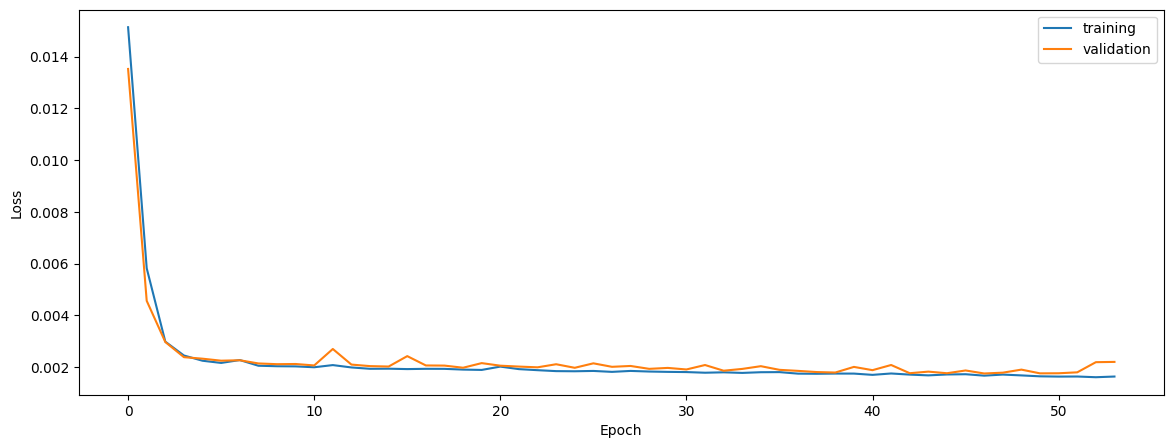

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


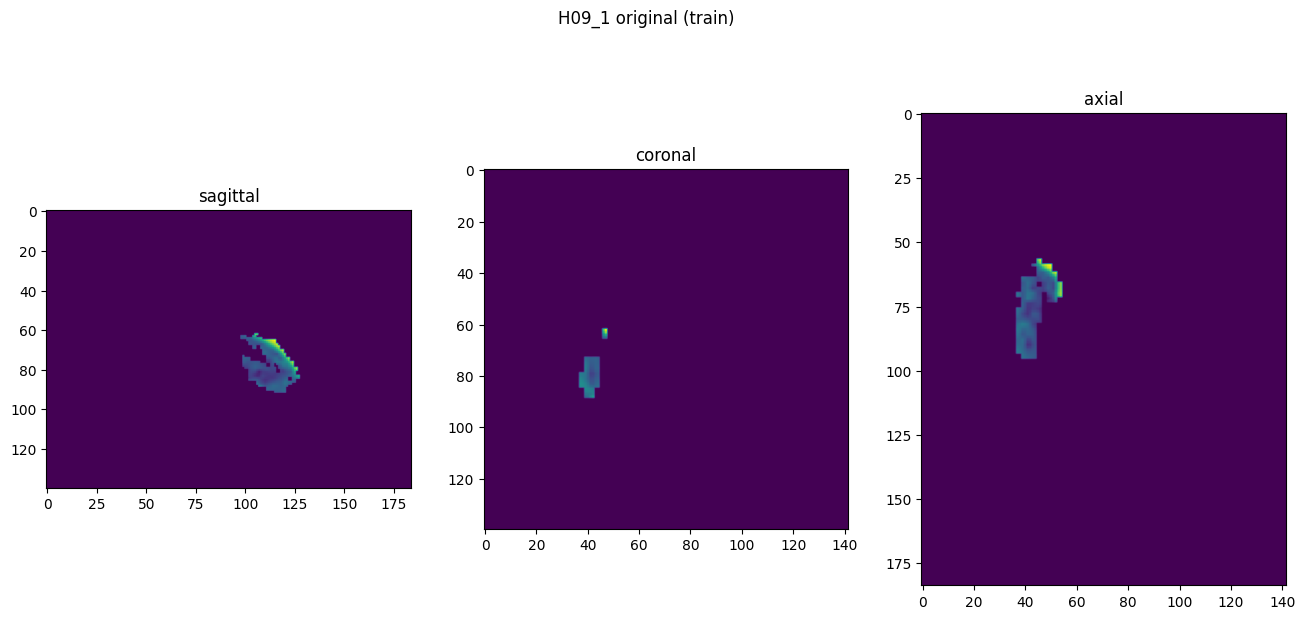

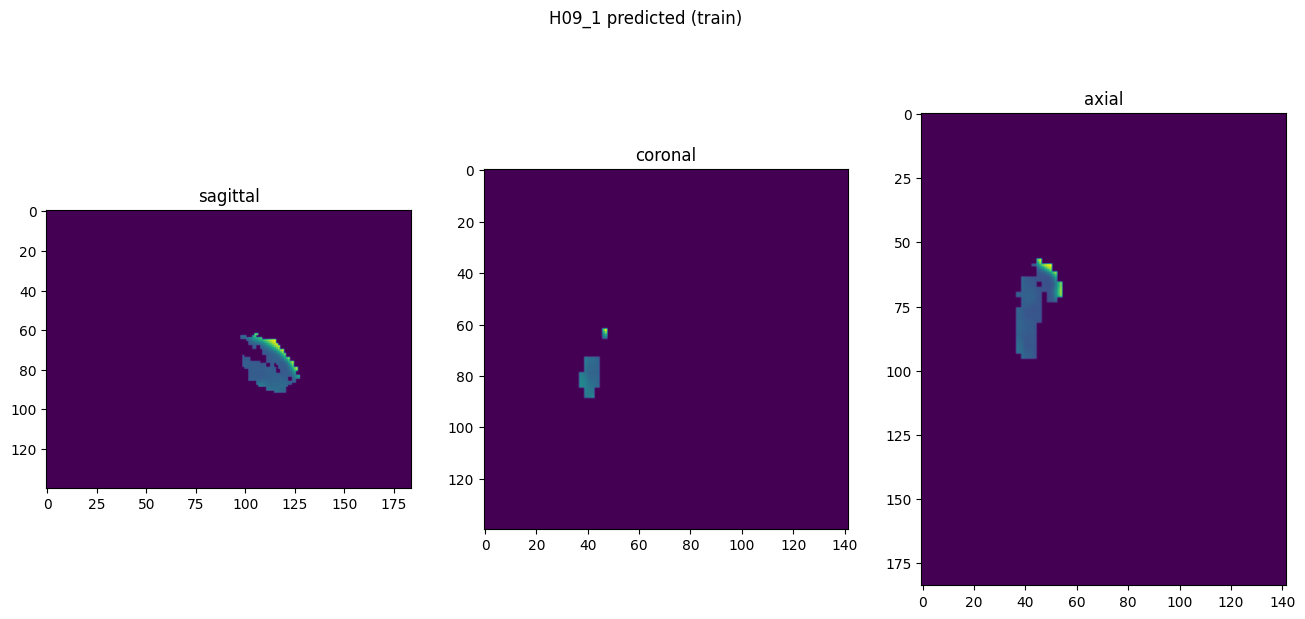

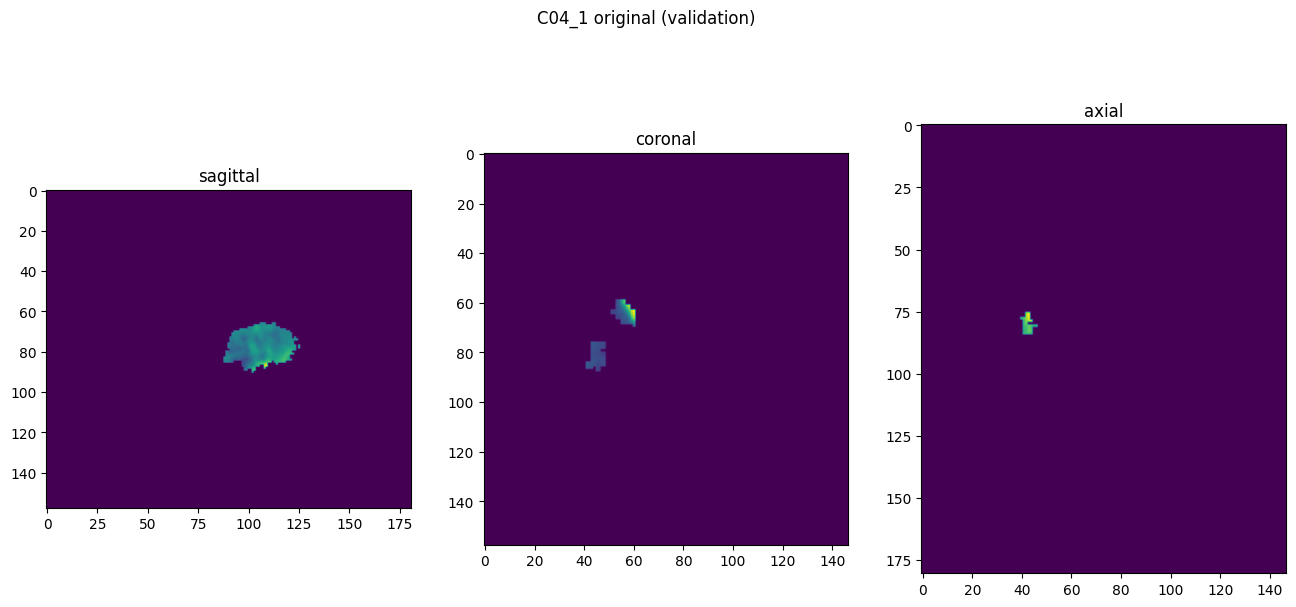

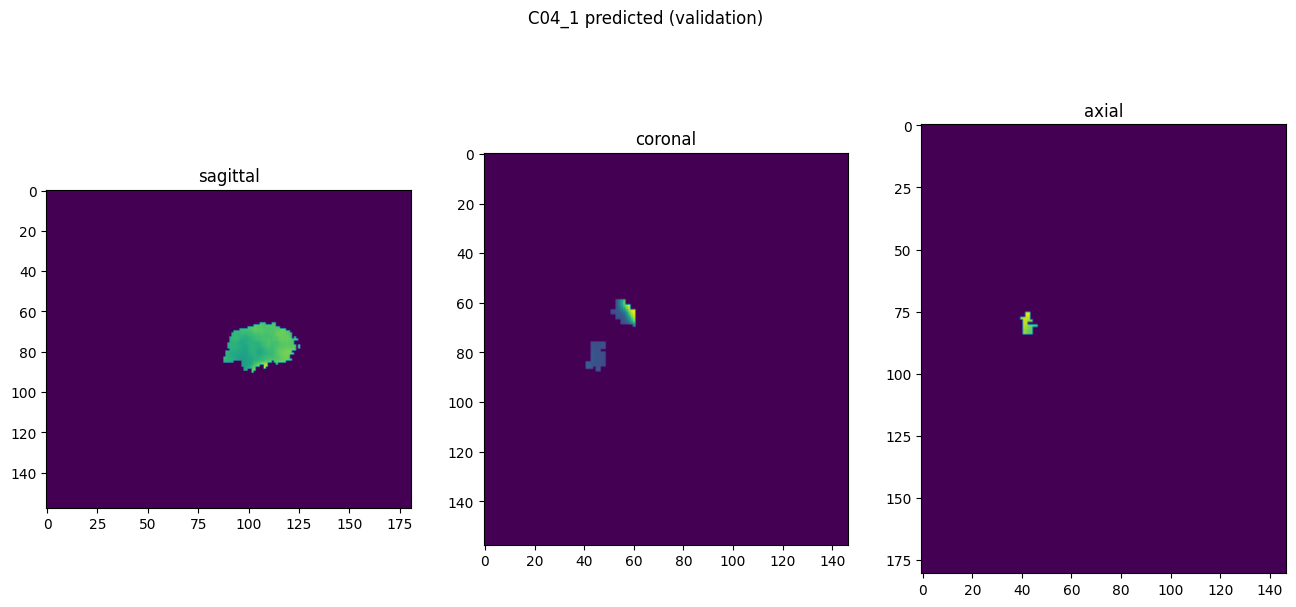

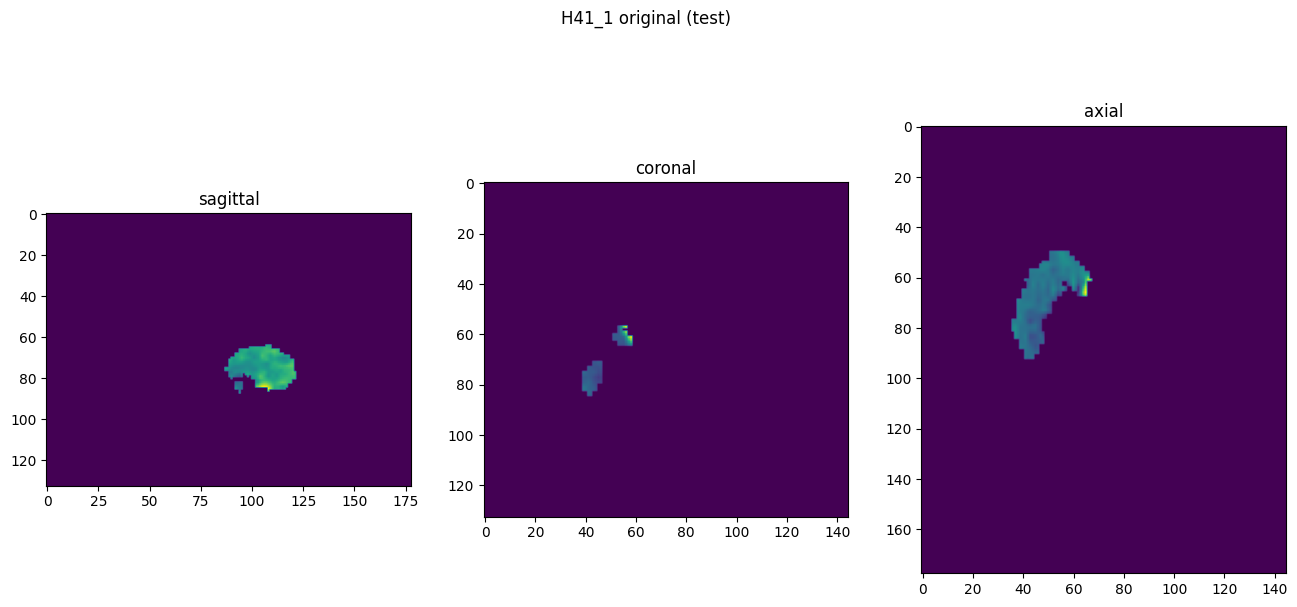

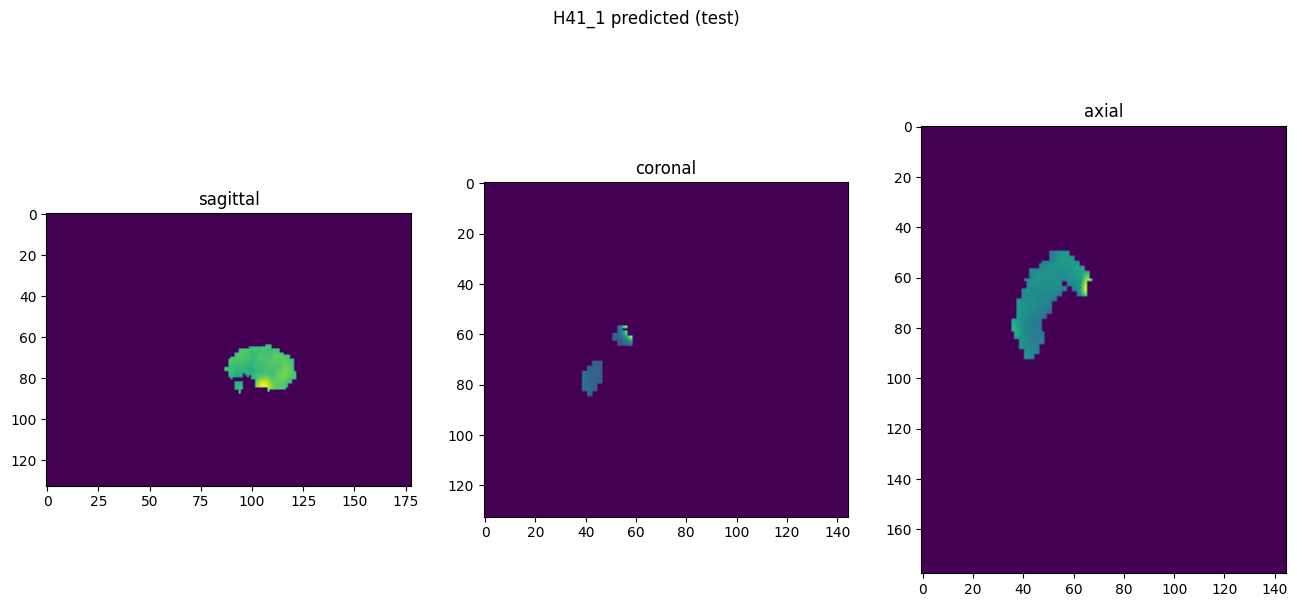

In [10]:
showResults(model, gen, threshold=None, background=False)